In [ ]:
!pip install transformers datasets rouge-score nltk torch optuna bert-score


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from rouge_score import rouge_scorer
from torch.utils.data import DataLoader
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score
import optuna
import os
import matplotlib.pyplot as plt

# Ensuring necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Loading BART model and tokenizer
bart_model_name = 'facebook/bart-large'
print(f"Loading BART model: {bart_model_name}")
tokenizer = BartTokenizer.from_pretrained(bart_model_name)
model = BartForConditionalGeneration.from_pretrained(bart_model_name).to(device)

# Initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


/home/desai226/.local/lib/python3.9/site-packages/transformers/loss/loss_for_object_detection.py:28: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import linear_sum_assignment
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/desai226/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/desai226/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Loading BART model: facebook/bart-large


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Function to remove rows with missing data
def remove_missing_data(dataset, columns):
    return dataset.filter(lambda x: all(x[col] is not None for col in columns))

# Function to load and clean dataset
def load_and_clean_data():
    train_data = load_dataset("ragha92/FNS_Summarization", split="train")
    validation_data = load_dataset("ragha92/FNS_Summarization", split="validation")
    test_data = load_dataset("ragha92/FNS_Summarization", split="test")

    columns = ['Annual Reports', 'Gold Summaries']
    train_data = remove_missing_data(train_data, columns)
    validation_data = remove_missing_data(validation_data, columns)
    test_data = remove_missing_data(test_data, columns)

    return train_data, validation_data, test_data


train_data, validation_data, test_data = load_and_clean_data()
print("Datasets loaded and cleaned.")


Datasets loaded and cleaned.


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score

# Model evaluation
def evaluate_model(dataset, params):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'bleu': [], 'meteor': [], 'bertscore': []}
    smooth = SmoothingFunction().method4

    references, candidates = [], []

    for item in dataset:
        input_text = item['Annual Reports']
        gold_summary = item['Gold Summaries']

        # Generating prediction
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
        outputs = model.generate(
            inputs['input_ids'],
            max_length=params['max_length'],
            min_length=params['min_length'],
            num_beams=params['num_beams'],
            length_penalty=params['length_penalty']
        )
        generated_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

        references.append(gold_summary)
        candidates.append(generated_summary)

        # Calculating ROUGE and BLEU
        rouge_scores = scorer.score(gold_summary, generated_summary)
        scores['rouge1'].append(rouge_scores['rouge1'].fmeasure)
        scores['rouge2'].append(rouge_scores['rouge2'].fmeasure)
        scores['rougeL'].append(rouge_scores['rougeL'].fmeasure)
        scores['bleu'].append(sentence_bleu([gold_summary.split()], generated_summary.split(), smoothing_function=smooth))

        # Tokenizing the gold summary and generated summary before passing to METEOR
        gold_summary_tokens = word_tokenize(gold_summary.lower())  # Lowercase for consistency
        generated_summary_tokens = word_tokenize(generated_summary.lower())  # Lowercase for consistency

        # Calculating METEOR
        scores['meteor'].append(meteor_score([gold_summary_tokens], generated_summary_tokens))

    # Calculating BERTScore
    P, R, F1 = score(candidates, references, lang="en", verbose=True)
    scores['bertscore'] = F1.numpy().tolist()


    return {metric: sum(values) / len(values) for metric, values in scores.items()}


In [ ]:
import optuna
from torch.utils.data import DataLoader
from transformers import AdamW

# Objective function for hyperparameter tuning
def objective(trial):
    # Hyperparameter tuning for learning rate, num_beams, length_penalty, max_length, and min_length
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_beams = trial.suggest_int('num_beams', 2, 10)
    length_penalty = trial.suggest_uniform('length_penalty', 0.5, 2.0)
    max_length = trial.suggest_int('max_length', 256, 1024, step=64)
    min_length = trial.suggest_int('min_length', 50, 300, step=50)

    if min_length >= max_length:
        return float('inf')  # Invalid parameter combination

    # Loading training and validation datasets
    train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
    val_dataloader = DataLoader(validation_data, batch_size=2, shuffle=False)

    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    total_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_texts = batch['Annual Reports']
        target_summaries = batch['Gold Summaries']

        inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
        targets = tokenizer(target_summaries, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

        outputs = model(input_ids=inputs['input_ids'], labels=targets['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss  # Minimize average loss


In [ ]:
# Creating study and start hyperparameter tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Displaying best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2024-12-03 14:38:32,795] A new study created in memory with name: no-name-6fb0d56c-1403-471c-a5d7-120d83f6443c
/tmp/ipykernel_102957/959736802.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/tmp/ipykernel_102957/959736802.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  length_penalty = trial.suggest_uniform('length_penalty', 0.5, 2.0)
/home/desai226/.local/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True

Best Hyperparameters: {'learning_rate': 2.3242866802875915e-05, 'num_beams': 5, 'length_penalty': 1.9073379966094826, 'max_length': 576, 'min_length': 150}


In [ ]:
#Function for fine tuning the model with best parameters
def fine_tune_with_best_params(data, best_params, epochs=3):
    model.train()
    optimizer = AdamW(model.parameters(), lr=best_params['learning_rate'])
    dataloader = DataLoader(data, batch_size=2, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()
            input_texts = batch['Annual Reports']
            target_summaries = batch['Gold Summaries']

            inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
            targets = tokenizer(target_summaries, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

            outputs = model(input_ids=inputs['input_ids'], labels=targets['input_ids'])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

fine_tune_with_best_params(train_data, study.best_params, epochs=3)


Epoch 1/3, Loss: 6.319612236393308
Epoch 2/3, Loss: 6.306895418537473
Epoch 3/3, Loss: 6.299932067371109


In [ ]:
# Evaluaingt model on the validation and test datasets
val_scores = evaluate_model(validation_data, study.best_params)
test_scores = evaluate_model(test_data, study.best_params)

# Displaying evaluation metrics
print("Validation Scores:", val_scores)
print("Test Scores:", test_scores)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 9.58 seconds, 26.82 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 9.27 seconds, 27.94 sentences/sec
Validation Scores: {'rouge1': 0.1739079638755416, 'rouge2': 0.013352453716130652, 'rougeL': 0.10466099914006591, 'bleu': 0.0015033239696082277, 'meteor': 0.05956857844917665, 'bertscore': 0.7405142276203586}
Test Scores: {'rouge1': 0.16950537097209292, 'rouge2': 0.012719390083020761, 'rougeL': 0.10272006752888897, 'bleu': 0.0015017295984651295, 'meteor': 0.05783709206884825, 'bertscore': 0.7382355392209351}


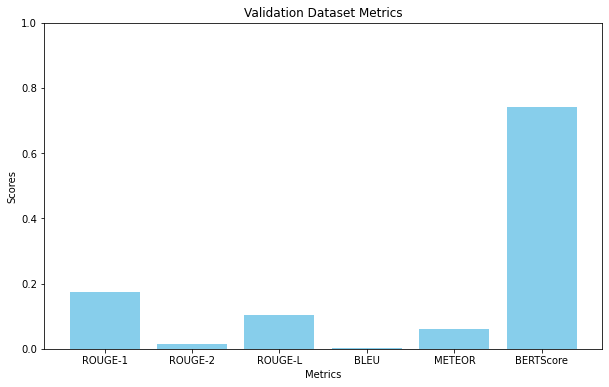

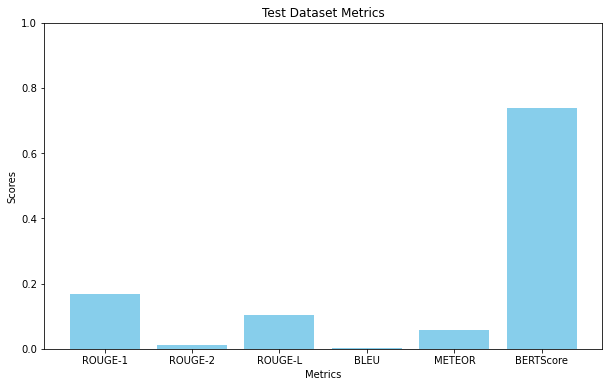

In [ ]:
def visualize_metrics(metrics, metric_names, dataset_type="Validation"):
    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metrics, color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{dataset_type} Dataset Metrics')
    plt.ylim(0, 1)
    plt.show()

# Visualizing validation and test metrics
metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR', 'BERTScore']
visualize_metrics(list(val_scores.values()), metric_names, dataset_type="Validation")
visualize_metrics(list(test_scores.values()), metric_names, dataset_type="Test")
